In [1]:
"""
Prediction file: Based on the trained neural network,see the performace on the testing set
Mapping Sim1->Sim 2 (Fig 3)

General workflow
Load test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> 
Decode into higher dimensional representation using SD VAE-> Display 


Note: This file has issues with loading both the pre-trained VAE and the trained model together with gpu.
One temporary fix I do is I encode the images using a CPU, but it takes a lot of time. 
In model training, the encoding of the outputs is done in a seperate script using a seperate GPU, and saved as a pickle file. 
In the training script, the latents are loaded from a pickle file. 
"""

'\nPrediction file: Based on the trained neural network,see the performace on the testing set\nMapping Sim1->Sim 2 (Fig 3)\n\nGeneral workflow\nLoad test data->Load trained dilResNet model and predict the output(are in latent representation) on test set-> \nDecode into higher dimensional representation using SD VAE-> Display \n\n\nNote: This file has issues with loading both the pre-trained VAE and the trained model together with gpu.\nOne temporary fix I do is I encode the images using a CPU, but it takes a lot of time. \nIn model training, the encoding of the outputs is done in a seperate script using a seperate GPU, and saved as a pickle file. \nIn the training script, the latents are loaded from a pickle file. \n'

In [12]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
from PIL import Image


from models.vae import vae, encode_img,decode_img
from models.dilResNet import PDEArenaDilatedResNet
import pickle

from utils.config import SIMULATION_TEST_OUTPUT_FOLDER, SIMULATION_TEST_OUTPUT_FOLDER_2
from utils.config import SIMULATION_TEST_OUTPUT_FOLDER_TDB, SIMULATION_TEST_OUTPUT_FOLDER_TDB_2    
from utils.config import LATENT_OUTPUT_SAVED,MODEL_DILRESNET_FIG3 

from utils.display import display_predicted_images, display_images_with_ssim, display_predicted_images_5X
from utils.preprocess import preprocess_simulation_input_data,preprocess_simulation_output_data,scale_latents,process_tensor_batch_with_grayfordisplay



In [2]:

'''
Loading test data for model testing

'''

# note the weird naming is because the same files served as output in Fig 2, but now are input

path_input=SIMULATION_TEST_OUTPUT_FOLDER
path_input_2=SIMULATION_TEST_OUTPUT_FOLDER_2   

path_output=SIMULATION_TEST_OUTPUT_FOLDER_TDB
path_output_2=SIMULATION_TEST_OUTPUT_FOLDER_TDB_2

# output data
start_index = 0  
end_index = 8   
output_data=preprocess_simulation_output_data(path_output, start_index, end_index)


## add some of the images from the main dataset that hasn't been used to train the network 

start_index = 70000  
end_index = 70025 
output_data_2=preprocess_simulation_output_data(path_output_2, start_index, end_index)

output_data.extend(output_data_2)

# input data
# note again the weird naming is because we use the similar process to how the "outputs" are processed
start_index = 0  
end_index = 8   
input_data=preprocess_simulation_output_data(path_input, start_index, end_index)


start_index = 70000  
end_index = 70025 
input_data_2=preprocess_simulation_output_data(path_input_2, start_index, end_index)

input_data.extend(input_data_2)

X=input_data
y=output_data


# size of input data is 32x32 and output data is 256x256
X=(np.array(X).reshape(-1,1,256,256)) #/255.0  # last one is grayscale first minus one is all x
y=(np.array(y).reshape(-1,1,256,256)) #/255.0


# normalizing images here to be bw 0 and 1 

X=X/255.0 
y=y/255.0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Convert numpy arrays to torch tensors
X = torch.Tensor(X)
y = torch.Tensor(y)



In [3]:
type(X)

torch.Tensor

In [4]:

'''
Defining dilResNet model for loading model weights
'''

# Example usage
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels (e.g., RGB image)
    out_channels=4,              # Output channels (e.g., RGB image or latent channels)
    hidden_channels=64,          # Number of hidden channels
    num_blocks=18,               # Number of dilated blocks (similar to number of ResNet blocks)
    dilation_rates=[1, 2, 4, 8], # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)



In [5]:
'''
Define pre-trained SD VAE for decoding orginal predicted patterns from the latent predicted patterns
dilResnet will predict latent representation of patterns

The difference here compared to training seed to simulation is that the input also needs to be encoded before
being supplied as input to the network-- this is the memory bottleneck

'''
# implement chunking procedure to avoid OOMs

device =torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoded_latents = []

# encode latent of intermeditate test  images
# do in batches to avoid OOMs

batch_size = 8  
for i in range(0, X.shape[0], batch_size):
    batch = X[i:i+batch_size]
    latent = encode_img(batch)
    encoded_latents.append(latent.cpu())



# encoded_latents_squeezed=[t.squeeze(0) for t in encoded_latents]

# stacked_tensor = torch.stack(encoded_latents_squeezed, dim=0)


# Simulating input image data as a list of random torch tensors
# input_images_list=encoded_latents

# Convert the list of tensors to a numpy array
# image_np_input = np.concatenate(input_images_list, axis=0)


# image_input=torch.tensor(image_np_input)

image_np_input = torch.cat(encoded_latents, dim=0).numpy()
image_input=torch.tensor(image_np_input)

MODEL_DILRESNET_FIG3_FILE='Pixel_32x32x3to32x32x4_dilRESNET_graypatterns_intermediatetocomplex_Model_30000_v102_9-1759430803'  # change this to the name of the model you want to load
MODEL_DILRESNET_FIG3=f'/hpc/group/youlab/ks723/miniconda3/saved_models/trained/{MODEL_DILRESNET_FIG3_FILE}.pt'

model.load_state_dict(torch.load(MODEL_DILRESNET_FIG3))
model.to(device)

model.eval()



with torch.no_grad():
    predicted_latents=model(image_input.to(device))   #y3   stacked_tensor is the input seed with 3 channels for the UNET

predicted_latents_rescaled=predicted_latents

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents_rescaled.cpu())   #  Note the .cpu()

# for generation see first row seed, second row final patterns, third row generated patterns


(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


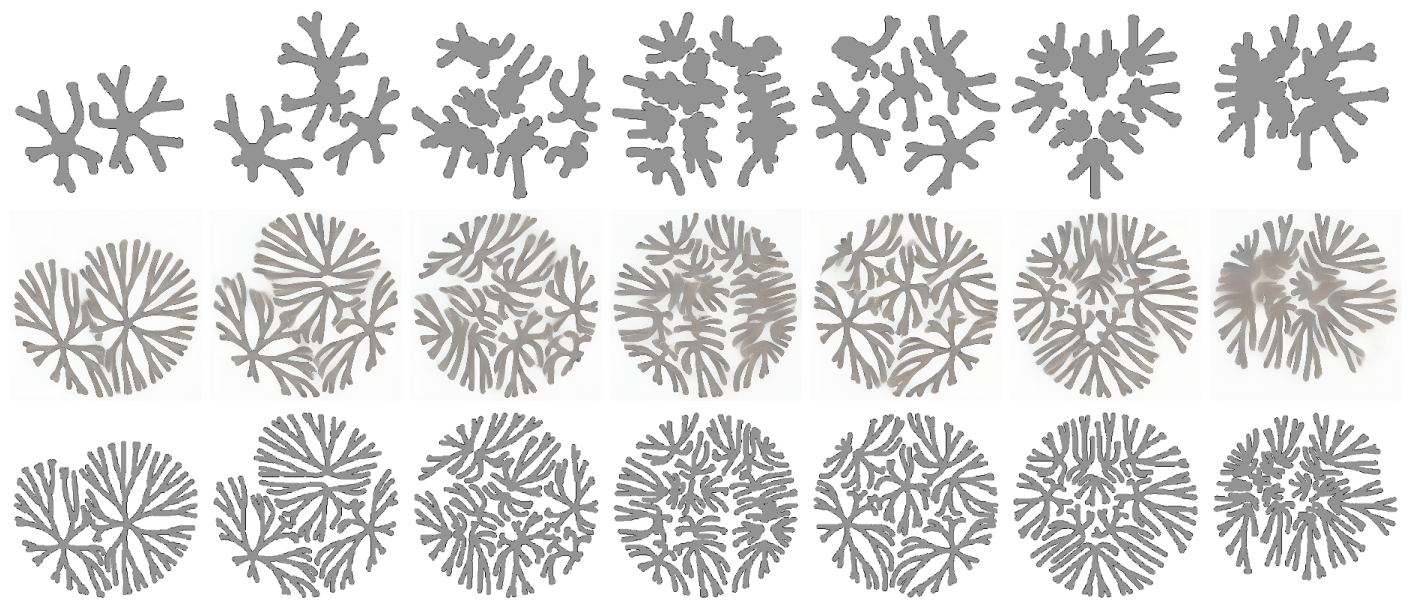

In [6]:
'''
Displaying simulation 1, actual simulation 2 and predicted simulation 2

For reference, simulation 1 is from the "intermediate" folder and simulation 2 is from the "complex" folder. simulation 1 is also
the default sim configuration. 

'''


selected_indices=[14,18,9,10,4,5,2] 
# Display samples from train dataset
order=[0,2,1]

# y_gray=process_tensor_batch_with_grayfordisplay(y,img_length=256,img_width=256,img_type='sim')
# X_gray=process_tensor_batch_with_grayfordisplay(X,img_length=256,img_width=256,img_type='sim')
# pred_images_gray=process_tensor_batch_with_grayfordisplay(pred_images,img_length=256,img_width=256,img_type='sim')


display_predicted_images(X[selected_indices,:,:,:],y[selected_indices,:,:,:], pred_images[selected_indices,:,:,:] ,len(selected_indices), order=order)   #
    
# selected_indices = [4, 5, 2, 10, 14]
# # Display samples from train dataset
# display_predicted_images(X[selected_indices],y[selected_indices], pred_images[selected_indices] ,5)   # 

Sample 0: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 1: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 2: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 3: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 4: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 5: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)
Sample 6: ref_image.shape = (1, 256, 256), comp_image.shape = (3, 256, 256)


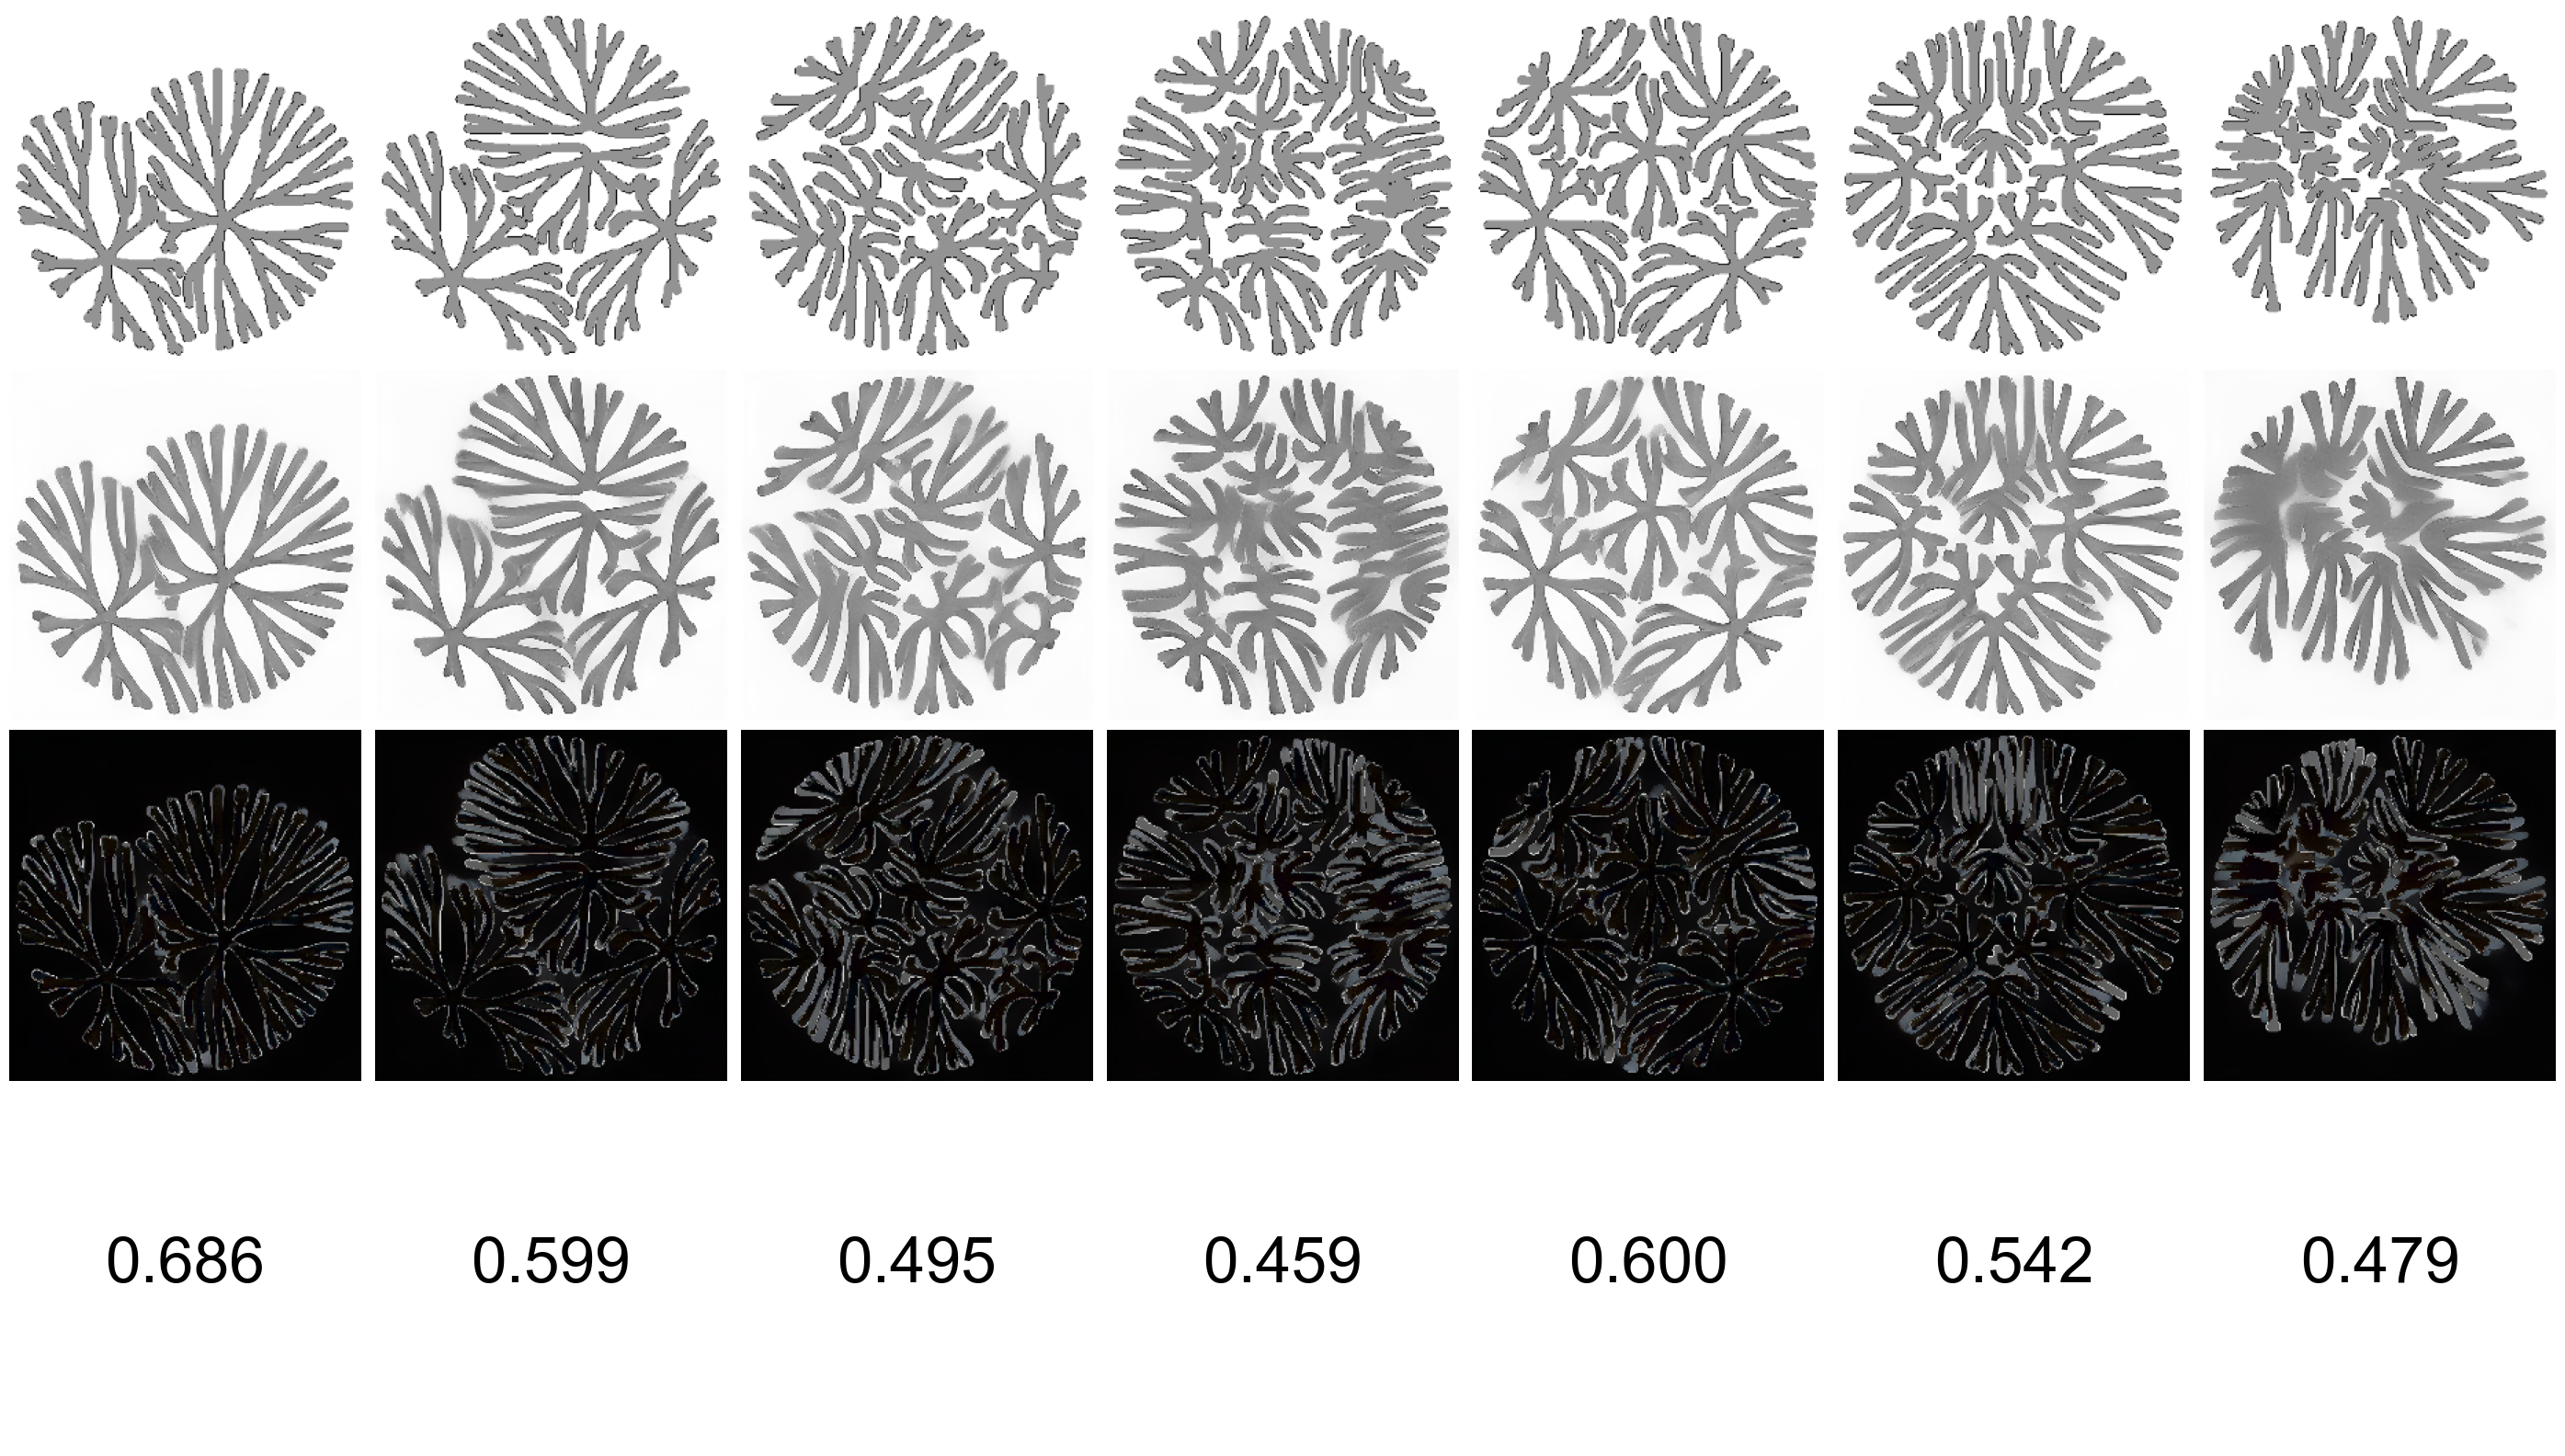

In [7]:
'''
Results represent images that have similar number of seeds as training set, but spatial positioning is different
'''
selected_indices = [14,18,9,10,4,5,2] 

# Assuming X and pred_images are already defined
display_images_with_ssim(y[selected_indices], pred_images[selected_indices], num_samples=7) 

### The following is for seeing the performance on training/validation images for a baseline of how the network is doing. This is done for now by loading images that are in the training set, and applying the final prediction model on that set. Will have to improve this later like seeing the performance in training by using lightning or tensorboard

In [8]:
# import libraries 

import os
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL
import pickle

In [9]:
'''
Loading from training data 
'''


# Here we are predicting the final patterns (intermediate) from the input seeding configuration 

input_data=[]
output_data=[]

path_output_2=SIMULATION_TEST_OUTPUT_FOLDER_TDB_2
path_input_2=SIMULATION_TEST_OUTPUT_FOLDER_2

## add some of the images from the main dataset that has been used to train the network

start_index = 0 
end_index = 100
output_data=preprocess_simulation_output_data(path_output_2, start_index, end_index)

# input data
 
input_data=preprocess_simulation_output_data(path_input_2, start_index, end_index)

X=input_data  
y=output_data

y=(np.array(y).reshape(-1,1,256,256))  
X=(np.array(X).reshape(-1,1,256,256))

# normalizing images here to be bw 0 and 1 
y=y/255.0
X=X/255.0 

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

X = torch.Tensor(X)
y = torch.Tensor(y)



In [15]:

# Define the dilResNet model
model = PDEArenaDilatedResNet(
    in_channels=4,               # Input channels 
    out_channels=4,              # Output channels 
    hidden_channels=64,          # Number of hidden channels
    num_blocks=18,               # Number of dilated blocks 
    dilation_rates=[1, 2, 4, 8],   # Dilation rates for multi-scale feature capture
    activation=nn.ReLU,          # Activation function
    norm=True                    # Use BatchNorm after each convolution
)


In [13]:

'''
Since we are dealing with training dataset, the latents for simulation input have already been encoded and saved as pickle files
Here we just load them from the pickle files
'''


pickle_in=open(LATENT_OUTPUT_SAVED,"rb")
yprime=pickle.load(pickle_in)

yprime=yprime[:100,:,:,:]
yprime=torch.Tensor(yprime)


yprime_scaled=scale_latents(yprime)
yprime_scaled=yprime_scaled.float()




In [16]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vae.to(device) # now put on gpu


model.load_state_dict(torch.load(MODEL_DILRESNET_FIG3))
model.to(device)

model.eval()
with torch.no_grad():
    predicted_latents=model(yprime[0:9,:,:,:].to(device))  #y3 is the input seed with 3 channels for the UNET 


predicted_latents_rescaled=scale_latents(predicted_latents)

# use the vae decoder to convert the encoded images to final patterns

pred_images=decode_img(predicted_latents)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


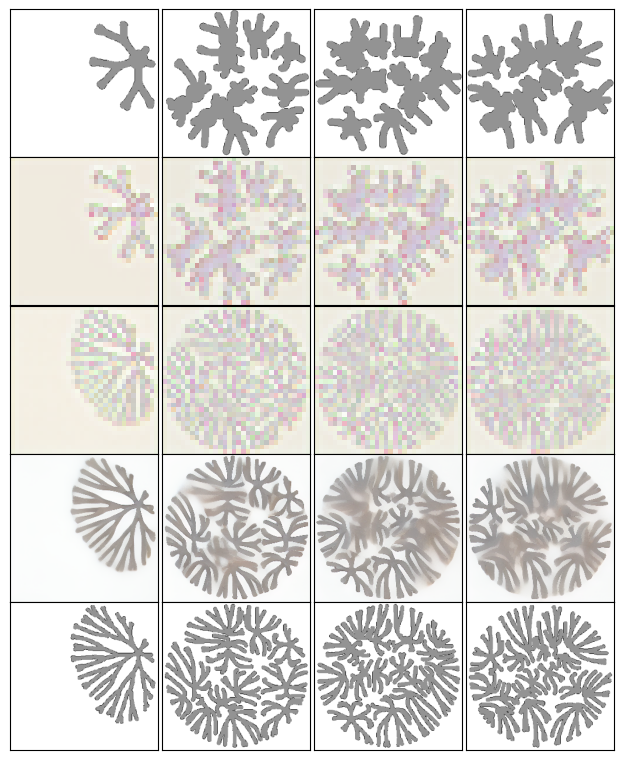

In [17]:
'''
Displaying simulation 1, latent simulation 1, predicted latent simulation 2, predicted simulation 2 and actual simulation 2

For reference, simulation 1 is from the "intermediate" folder and simulation 2 is from the "complex" folder. simulation 1 is also
the default sim configuration. 

'''

# Display samples from train dataset

display_predicted_images_5X(X[0:9,:,:,:],yprime_scaled[0:9,:,:,:],predicted_latents_rescaled[0:9,:,:,:],pred_images[0:9,:,:,:],y[0:9,:,:,:] ,4) # 
